In [52]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
        )
    out_dir = './dataset'
    
    train=datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)
    test=datasets.FashionMNIST(root=out_dir, train=False, transform=compose, download=True)
    
    return train, test 



# Load data
traindata, testdata = Fashion_mnist_data()
train_loader = torch.utils.data.DataLoader(traindata, batch_size=100, shuffle=True)
test_loader=torch.utils.data.DataLoader(testdata, batch_size=100, shuffle=True)
# Num batches
num_batches = len(train_loader)  #600
print(len(test_loader))  #100

100


In [53]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 10
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

In [72]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [55]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [56]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    

In [57]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss= nn.CrossEntropyLoss()


In [58]:
#test model
def evaluate(model, dataset, criterion):    
    test_loss = 0
    test_acc = 0
    acc=0   
    N=100
    model.eval()    
    with torch.no_grad():    
        for inputs, labels in dataset:             
            real_data=images_to_vectors(inputs)
            pred=model(real_data) 
            loss = criterion(pred, labels.long())             
            test_acc += torch.sum(torch.argmax(pred, dim=1) == labels).item()            
            test_loss += loss.item()
                  
    return test_loss /N, test_acc /N

In [59]:
# train D as a classifer 
   
optimizer = optim.Adam(discriminator.parameters(), lr=0.001)   
loss= nn.CrossEntropyLoss()
epochs=80

Loss1=[]
Loss2=[]
Acc1=[]
Acc2=[]
N=600

for i in range(epochs):
    train_loss=0
    train_acc=0
    discriminator.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        real_data=images_to_vectors(inputs) 
        out=discriminator(real_data)  
        error= loss(out, labels.long())
        error.backward()
        optimizer.step()
        
        # statitic loss
        train_loss += error.item()
        train_acc += torch.sum(torch.argmax(out, dim=1) == labels).item()
        
   
    test_loss, test_acc=evaluate(discriminator, test_loader, loss)
    
    Loss1.append(train_loss/N)
    Loss2.append(test_loss)
    Acc1.append(train_acc/N)
    Acc2.append(test_acc)
    
    print("epoch train loss:",train_loss/N, "Acc:", train_acc/N, "test_loss:",  test_loss,"test_acc:" ,test_acc)

    

epoch train loss: 0.5652979350090027 Acc: 79.53666666666666 test_loss: 0.4407712423801422 test_acc: 84.13
epoch train loss: 0.428389621352156 Acc: 84.435 test_loss: 0.41351878106594087 test_acc: 85.44
epoch train loss: 0.39195783170560994 Acc: 85.89166666666667 test_loss: 0.38283736288547515 test_acc: 86.43
epoch train loss: 0.3738751944154501 Acc: 86.41 test_loss: 0.3741066715121269 test_acc: 86.61
epoch train loss: 0.35506475607554117 Acc: 87.22833333333334 test_loss: 0.3597383435070515 test_acc: 86.84
epoch train loss: 0.3400972378005584 Acc: 87.64166666666667 test_loss: 0.37152022138237956 test_acc: 86.85
epoch train loss: 0.32954443035026393 Acc: 88.03166666666667 test_loss: 0.3654682901501656 test_acc: 86.76
epoch train loss: 0.3206926089525223 Acc: 88.355 test_loss: 0.3394485993683338 test_acc: 88.15
epoch train loss: 0.3136321183294058 Acc: 88.47166666666666 test_loss: 0.3526961673796177 test_acc: 87.3
epoch train loss: 0.30335311878472565 Acc: 88.94166666666666 test_loss: 0.35

Text(0, 0.5, 'Accuracy %')

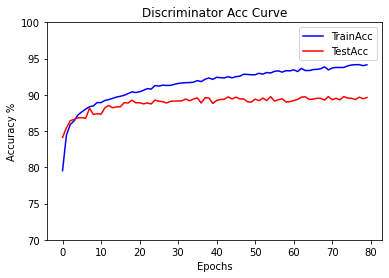

In [71]:
## plot 
plt.title('Discriminator Acc Curve')
plt.plot(Acc1,'b')
plt.plot(Acc2,'r')
plt.ylim((70, 100))
plt.legend(['TrainAcc','TestAcc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')

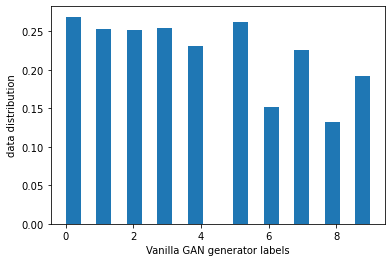

In [96]:
# load generator model 
PATH="/Users/dl/generator"
generator_dict=generator.load_state_dict(torch.load(PATH))
#generator.state_dict()

fake_data = generator(noise(3000)).detach()

prediction_fake = discriminator(fake_data)

pre_label=torch.argmax(prediction_fake, dim=1)


# plot histogram of predicted labels
plt.hist(pre_label, bins=20, density=True)
plt.xlabel('Vanilla GAN generator labels')
plt.ylabel('data distribution')
plt.show()

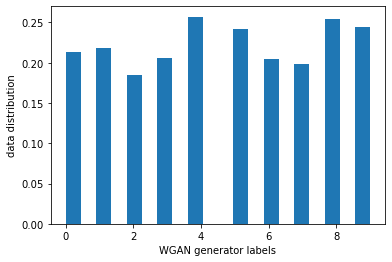

In [94]:
## compare 3000 examples from vanilla GAN, WGAN, unrolled GAN

# load generator model 
PATH="/Users/dl/gen_WGAN"
generator_dict=generator.load_state_dict(torch.load(PATH))
#generator.state_dict()

fake_data = generator(noise(3000)).detach()

prediction_fake = discriminator(fake_data)

pre_label=torch.argmax(prediction_fake, dim=1)

plt.hist(pre_label, bins=20, density=True)
plt.xlabel('WGAN generator labels')
plt.ylabel('data distribution')
plt.show()

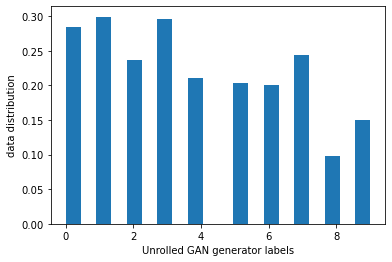

In [95]:
# load generator model 
PATH="/Users/dl/gen_unroll"
generator_dict=generator.load_state_dict(torch.load(PATH))
#generator.state_dict()

fake_data = generator(noise(3000)).detach()

prediction_fake = discriminator(fake_data)

pre_label=torch.argmax(prediction_fake, dim=1)

plt.hist(pre_label, bins=20, density=True)
plt.xlabel('Unrolled GAN generator labels')
plt.ylabel('data distribution')
plt.show()